# San Francisco Bike Share Prediction Model 

I have done a previous analysis on bike share data of San Francisco where I extracted trends and patterns from the data. I found a different set of ride share data that that has a few new columns, which will come in handy when creating a prediction model. I want to create a model that will predict how many bike rides are taken on a daily basis, as a continuation of the analysis. Highly recommed taking a look at it, https://github.com/medmorales/Data-Exploration/blob/main/Lyft%20Analysis/BikeShareAnalysis.ipynb.



## Packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

/Users/miguelmorales/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading in the data

In [2]:
#station =  pd.read_csv('station.csv')
#status =  pd.read_csv('status.csv')
#trip =  pd.read_csv('trip.csv')
#weather =  pd.read_csv('weather.csv')

## Trips DataFrame
The trips file has the bulk of our data. This is very similar to the data that I did an exploratory analysis on as mentioned at the top of this file. I highly recommend taking a look at that first. https://github.com/medmorales/Data-Exploration/blob/main/Lyft%20Analysis/BikeShareAnalysis.ipynb

In [3]:
trip =  pd.read_csv('trip.csv')

In [4]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [5]:
trip.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [6]:
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id
count,669959.000000,6.699590e+05,669959.000000,669959.000000,669959.000000
mean,460382.009899,1.107950e+03,57.851876,57.837438,427.587620
std,264584.458487,2.225544e+04,17.112474,17.200142,153.450988
min,4069.000000,6.000000e+01,2.000000,2.000000,9.000000
25%,231082.500000,3.440000e+02,50.000000,50.000000,334.000000
50%,459274.000000,5.170000e+02,62.000000,62.000000,440.000000
75%,692601.000000,7.550000e+02,70.000000,70.000000,546.000000
max,913460.000000,1.727040e+07,84.000000,84.000000,878.000000


In [7]:
trip.nunique()

id                    669959
duration               16129
start_date            361559
start_station_name        74
start_station_id          70
end_date              357757
end_station_name          74
end_station_id            70
bike_id                  700
subscription_type          2
zip_code                7439
dtype: int64

Here I just wanted to see the number of unique values in the data frame to gain a better understanding of the # of stations, subscription types, etc..

### Percent of Missing Data

In [8]:
#### Missing Data 
np.round(trip.isnull().sum()/len(trip)*100, decimals =2)

id                    0.00
duration              0.00
start_date            0.00
start_station_name    0.00
start_station_id      0.00
end_date              0.00
end_station_name      0.00
end_station_id        0.00
bike_id               0.00
subscription_type     0.00
zip_code              0.99
dtype: float64

As we can see, the zip code column has about 1% of it's data missing. However, this information is not important to us. From this dataset, we are interested in using it to calcualte the # of rides per date. This means that the zip code is just not a column of interest, so there is no need to investigate or populate the missing values for it. 

What is of note is that our date columns are not missing any data. 

### Duration: Let's explore the duration of the trips. 
When looking at the output after using the describe function earlier, there seems to be some questionable and unrealistic ride durations, so we'll take a closer look.

The duration uses the units seconds, I want to change this to minutes for clarity. To do this we will simply divide the number of seconds by 60.

In [9]:
# The duration uses the units seconds, I want to change this to minutes for clarity.
trip['duration']= trip['duration']/60

In [10]:
trip.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

From this output, we know that there are outliers in the data. Especially seeing the trip with the highest duration being one that lasted 287,840 minutes. I do no think it is realistic for someone to have taken a 287,840 minute bike ride, so the outliers might be the result of recording errors. Therefore, I will look into removing them prior to running the model. I am going to continue looking at the different data thats available, but will be thinking about my options for these outliers, maybe reducing the amount of outliers by creating a cutoff. With outliers like this, the data does not seem normal, complicating what we can do to identify outliers.  

In [11]:
#trip = trip.loc[trip.duration < 360]

### Start Date
The start_date column will be essential to our model as it will be the date at which we will use to count the number of daily trips, our Dependent (x) variable that we will be predicting.  

In [12]:
# transform object type to datetime
# trip.start_date = pd.to_datetime(trip.start_date, format='%m/%d/%Y %H:%M')

In [15]:
# small function to change object date type to datetime. Will use in other datesets.
def to_datetime(df_name, column):
    df_name[column] = pd.to_datetime(df_name[column], format='%m/%d/%Y %H:%M')
    return df_name[column]

In [16]:
to_datetime(trip, 'start_date')

0        2013-08-29 14:13:00
1        2013-08-29 14:42:00
2        2013-08-29 10:16:00
3        2013-08-29 11:29:00
4        2013-08-29 12:02:00
                 ...        
669954   2014-09-01 04:21:00
669955   2014-09-01 03:16:00
669956   2014-09-01 00:05:00
669957   2014-09-01 00:05:00
669958   2014-09-01 00:05:00
Name: start_date, Length: 669959, dtype: datetime64[ns]

### Trip Duration Outlier Detection and Removal 

The reason we are interested in the duration of the trips is becasue we are counting the number of trips per day. If a trip is over 1 day long, is that a real trip or is that trip a result of a recording error? We've already seen above that there are trips that last over a day long so I think it is reasonable to assume that there are not legitimate trips. 

For the most part, when detecting and removing outliers, we use one of two main methods, using the Z-Score or Interquartile Range.

##### Z-Score

The z-score is the number of standard deviations that a value of an observation is above or below the mean value of the observations that are being measured. 

The formula for the z-szore is given by: $ z = (x - mean) / sd $

In order to use the z-score we need the assumption that the data has a Gaussian Distribution, also known as a Normal distribution. 

In finding the z-score, we rescale and center the data, and look for data points that are too far away from the mean. In this case we will use a threshold of 3 standard deviations away from the new mean. This is pretty standard way of defining what an outlier means when using the z-score method. 

So, I'll plot the distribution of the data to see if it passes the Normal assumption.

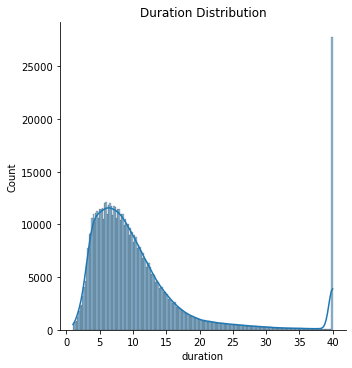

In [17]:
# Distribution of durations. 
sns.displot(x= np.clip(trip.duration, 0,40), data = trip, bins = 200, kde= True)
# sns.displot('duration', data = trip, bins = 20, kde= True)
plt.title('Duration Distribution')
plt.show()

Either way, the distribution of the this data, even after we shorten the x-axis to a max of 40 minutes is right skewed, so our data does not meet the assumptions of normaility to be able to use the z-score method in the first place.

#### Using a Cutoff Duration
So, we still need to come up with a way to remove these very long duration outliers. One way we can remove these problematic trips is by using a cut off for the duration value and only keeping the trips with durations up to a certain length. (This is not a robust way of removing outliers however)

In [18]:
len(trip.loc[trip.duration > 600])

1369

Over 10 hours? There are 1,369 bike trips that are at least 10 hours long. It is possible that someone can bike for that long, but I highly doubt that the majority of those trips are actually people biking for over 10 hours straight. These trips might be the result of glitches in recording. Let's remove these from our data. 

In [19]:
# Keep trips that are less than 10 hours long
trip = trip.loc[trip.duration < 600]

### Extracting Date and Caluclating Daily Counts

In [20]:
# Extracting date from start time
trip["only_date"] = [d.date() for d in trip["start_date"]]

In [21]:
def to_datetime2(df_name, column):
    df_name[column] = pd.to_datetime(df_name[column], format='%Y-%m-%d')
    return df_name[column]

In [22]:
# Calculating daily trips and creating new dataframe. 
daily_count = pd.DataFrame(trip['only_date'].value_counts().reset_index())
daily_count.columns = ['date', 'num_trips']

In [23]:
to_datetime2(daily_count, 'date')

0     2014-08-26
1     2014-09-15
2     2014-10-14
3     2014-10-29
4     2014-08-27
         ...    
728   2014-11-30
729   2014-03-29
730   2014-12-11
731   2014-02-08
732   2014-02-09
Name: date, Length: 733, dtype: datetime64[ns]

In [24]:
# sort the dataframe by date
train_trip = daily_count.sort_values('date')
train_trip.reset_index(drop = True, inplace = True)

In [25]:
print('The trips data has a date range between ' + str(train_trip.date.min()) 
      + ' and '+ str(train_trip.date.max()) + '.')

The trips data has a date range between 2013-08-29 00:00:00 and 2015-08-31 00:00:00.


In [26]:
train_trip.head()

,date,num_trips
0,2013-08-29,743
1,2013-08-30,708
2,2013-08-31,632
3,2013-09-01,700
4,2013-09-02,659


Now, we have successfuly calculated the number of bike rides per day given the date range in the Trip's dataset. This will be the focus of our model, predicting the number of trips, given the date. 

In [27]:
train_trip.to_csv('train_trip.csv')

## Station DataFrame

In [28]:
station =  pd.read_csv('station.csv')
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [29]:
station.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

Looking at the station dataframe, I think there is a great way to make use of it. Stations have different installation dates, possibly meaning that the amount of bikes available to take for ride share has changed over time because Lyft has grown and added new stations over time. So, an important variable in predicting the number of bike rides by date has to be the number of open stations, docks, and bikes at the time.  

So, lets calculate the number of docks at each date and combine that to our train_data set which is our modeling dataset. 

In [30]:
station.describe()

,id,lat,long,dock_count
count,70.000000,70.000000,70.000000,70.000000
mean,43.000000,37.590243,-122.218416,17.657143
std,24.166092,0.203473,0.209446,4.010442
min,2.000000,37.329732,-122.418954,11.000000
25%,24.250000,37.389483,-122.400601,15.000000
50%,43.500000,37.631163,-122.312123,15.000000
75%,63.750000,37.788123,-122.078009,19.000000
max,84.000000,37.804770,-121.877349,27.000000


In [31]:
station.nunique()

id                   70
name                 70
lat                  70
long                 70
dock_count            6
city                  5
installation_date    17
dtype: int64

#### Transforming and Extracting the Installation Date

In [32]:
# Extracting date from instillation time
# transform object type to datetime
# station.installation_date = pd.to_datetime(station.installation_date, format='%m/%d/%Y')
def to_datetime3(df_name, column):
    df_name[column] = pd.to_datetime(df_name[column], format='%m/%d/%Y')
    return df_name[column]

In [33]:
to_datetime3(station, 'installation_date')

0    2013-08-06
1    2013-08-05
2    2013-08-06
3    2013-08-05
4    2013-08-07
        ...    
65   2013-08-25
66   2013-12-31
67   2014-01-22
68   2014-02-20
69   2014-04-09
Name: installation_date, Length: 70, dtype: datetime64[ns]

In [34]:
station["installation_date"] = [d.date() for d in station["installation_date"]]

In [35]:
station['installation_date']

0     2013-08-06
1     2013-08-05
2     2013-08-06
3     2013-08-05
4     2013-08-07
         ...    
65    2013-08-25
66    2013-12-31
67    2014-01-22
68    2014-02-20
69    2014-04-09
Name: installation_date, Length: 70, dtype: object

In [36]:
print('The stations data has a date range between ' + str(station.installation_date.min()) 
      + ' and '+ str(station.installation_date.max()) + '.')

The stations data has a date range between 2013-08-05 and 2014-04-09.


The date range of the station installation dates basically fall between the the data range of our trip data. So this will be a great data point to have. 

Now, going back to what was interesting about this dataframe, calculating the dock counts for each date. So, lets get this done. 

In [37]:
# for each data in train_data, we will calculate the sum of dock_counts
avail_docks=[]
for date in train_trip.date:
    num = 0
    num = station.loc[station['installation_date'] <= date, 'dock_count'].sum()
    avail_docks.append(num)    

/Users/miguelmorales/opt/miniconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Now, we have succefully created a list of the number of available docks for each date in our dataframe. We'll go ahead and merge this list into our train dataset.

In [38]:
train_trip['dock_count'] = avail_docks

In [39]:
train_trip.head()

,date,num_trips,dock_count
0,2013-08-29,743,1150
1,2013-08-30,708,1150
2,2013-08-31,632,1150
3,2013-09-01,700,1150
4,2013-09-02,659,1150


In [40]:
train_trip.dtypes

date          datetime64[ns]
num_trips              int64
dock_count             int64
dtype: object

In [41]:
train_trip.to_csv('train_station.csv')

This is great, we are making progress!

## Weather Data

In [101]:
weather =  pd.read_csv('weather.csv')
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


This weather dataset has many good data points for specific dates. We can definitly use this in our model. 

In [102]:
weather.shape

(3665, 24)

In [103]:
weather.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [104]:
# calculating percentage of null values in columns
round(weather.isnull().sum()/(len(weather))*100, 2)

date                               0.00
max_temperature_f                  0.11
mean_temperature_f                 0.11
min_temperature_f                  0.11
max_dew_point_f                    1.47
mean_dew_point_f                   1.47
min_dew_point_f                    1.47
max_humidity                       1.47
mean_humidity                      1.47
min_humidity                       1.47
max_sea_level_pressure_inches      0.03
mean_sea_level_pressure_inches     0.03
min_sea_level_pressure_inches      0.03
max_visibility_miles               0.35
mean_visibility_miles              0.35
min_visibility_miles               0.35
max_wind_Speed_mph                 0.03
mean_wind_speed_mph                0.03
max_gust_speed_mph                24.53
precipitation_inches               0.03
cloud_cover                        0.03
events                            85.76
wind_dir_degrees                   0.03
zip_code                           0.00
dtype: float64

There seems to be two columns that are missing a significant amount of values.

In [105]:
# again we need to change the data type of the date column. 
#weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')
to_datetime3(weather,'date')

0      2013-08-29
1      2013-08-30
2      2013-08-31
3      2013-09-01
4      2013-09-02
          ...    
3660   2015-08-27
3661   2015-08-28
3662   2015-08-29
3663   2015-08-30
3664   2015-08-31
Name: date, Length: 3665, dtype: datetime64[ns]

In [106]:
weather.events.value_counts()

Rain                 388
Fog                  112
Fog-Rain              17
Rain-Thunderstorm      3
rain                   2
Name: events, dtype: int64

We can see here that there are two rain values. Let's convert all 'rain' to 'Rain' for more consistency. 

In [107]:
weather.loc[weather['events'] == 'rain', 'events'] = 'Rain'

In [108]:
weather.events.value_counts()

Rain                 390
Fog                  112
Fog-Rain              17
Rain-Thunderstorm      3
Name: events, dtype: int64

### Data Imputation on Missing Weather Data

In [109]:
# calculating percentage of null values in columns
round(weather.isnull().sum()/(len(weather))*100, 2)

date                               0.00
max_temperature_f                  0.11
mean_temperature_f                 0.11
min_temperature_f                  0.11
max_dew_point_f                    1.47
mean_dew_point_f                   1.47
min_dew_point_f                    1.47
max_humidity                       1.47
mean_humidity                      1.47
min_humidity                       1.47
max_sea_level_pressure_inches      0.03
mean_sea_level_pressure_inches     0.03
min_sea_level_pressure_inches      0.03
max_visibility_miles               0.35
mean_visibility_miles              0.35
min_visibility_miles               0.35
max_wind_Speed_mph                 0.03
mean_wind_speed_mph                0.03
max_gust_speed_mph                24.53
precipitation_inches               0.03
cloud_cover                        0.03
events                            85.76
wind_dir_degrees                   0.03
zip_code                           0.00
dtype: float64

### Strange Value In 'precipitation_inches' Column

Upon trying to fit the regression model, I came across an error in the 'precipitation_inches' column. Most values are in decimals, however, there is also a value of 'T' that is signficantly prominent throughout the data. We need to understand what this value means and think about replacing it with a number. 

In [110]:
#pd.set_option('display.max_rows', 500)
#weather.head(200)

#### PRECIPITATION_INCHES
#### Using The Median For Imputation

It looks like most T's that are in the data have an 'event' of either Rain or Fog-Rain. Therefore, we should replace the T's in the data with a precipitation amount. What amount should we use? Well I think we have two options, either replacing it with the mean or median of the percirpitation amount. However, I think it would be more accurate if we used the MEDIAN to impute the missing data at least in this columns

In [111]:
no_inches = ['T', '0']
median= weather[~weather['precipitation_inches'].isin(no_inches)]
median.precipitation_inches.median()

0.08

In [112]:
weather.loc[weather['precipitation_inches'] == 'T', 'precipitation_inches'] = '0.08'
weather['precipitation_inches'] = weather.precipitation_inches.astype('float')

We have successfully replaced all 'T' values with the median percipitation amount of 0.08. Now, all we have to do is convert this column from an object to float.

#### EVENTS COLUMN

In [113]:
weather.events.value_counts()

Rain                 390
Fog                  112
Fog-Rain              17
Rain-Thunderstorm      3
Name: events, dtype: int64

The events column is missing a lot of data. These values are NULL. There is no precipitation on these days and the non null events dont list a non rain or fog day. I think we can assume that these are just normal sunny or partly cloudy days. Let's impute these values with the label 'mild'.

In [114]:
weather.events.fillna('Mild', inplace = True)

In [115]:
weather.events.value_counts()

Mild                 3143
Rain                  390
Fog                   112
Fog-Rain               17
Rain-Thunderstorm       3
Name: events, dtype: int64

ALL ADDED!

Looking at the ZIPCODE counts in the weather dataset, we can see that there are a total of 733 unique dates and a total of 3665 total rows. Which should be enough to confirm that each date appears a total of five times. This is good informtion to know!

In [116]:
weather.zip_code.value_counts()

94107    733
94063    733
94301    733
94041    733
95113    733
Name: zip_code, dtype: int64

I initially thought that the weather data point was taken five seperate times per day, but now it looks like the weather data has a daily entry for the 5 unique zip_codes that are present. These zip codes stretch from San Francisco to San Jose. Due to their close proximity and for use in our model, it would be simplist to use only one zipcodes weather. So let's use one zip codes data for our weather subset in our model. 

How do we choose between the 5 Zipcodes?

The first thought that goes through my mind is by chopsing the one that occurs most often in our 'trips' dataset, since we are calculating our daily ride counts from there.

In [117]:
trip.zip_code.value_counts()

94107     78640
94105     42642
94133     31334
94103     26645
94111     21394
          ...  
113299        1
33637         1
48201         1
33024         1
95501         1
Name: zip_code, Length: 7372, dtype: int64

Looking at the top five, zip code counts from the trips dataset, they are all from San Francisco. So, I think it would be easiest to use 94107's (located in San Francisco) data from the weather dataset to supply us with our weather data points and revisit the missing data.

In [118]:
weather = weather.loc[weather['zip_code'] == 94107]

In [119]:
round(weather.isnull().sum()/(len(weather))*100, 2)

date                              0.00
max_temperature_f                 0.00
mean_temperature_f                0.00
min_temperature_f                 0.00
max_dew_point_f                   0.00
mean_dew_point_f                  0.00
min_dew_point_f                   0.00
max_humidity                      0.00
mean_humidity                     0.00
min_humidity                      0.00
max_sea_level_pressure_inches     0.00
mean_sea_level_pressure_inches    0.00
min_sea_level_pressure_inches     0.00
max_visibility_miles              0.00
mean_visibility_miles             0.00
min_visibility_miles              0.00
max_wind_Speed_mph                0.00
mean_wind_speed_mph               0.00
max_gust_speed_mph                1.77
precipitation_inches              0.00
cloud_cover                       0.00
events                            0.00
wind_dir_degrees                  0.00
zip_code                          0.00
dtype: float64

In [120]:
weather['max_gust_speed_mph']=weather['max_gust_speed_mph'].fillna(weather['max_gust_speed_mph'].mean())

In [121]:
round(weather.isnull().sum()/(len(weather))*100, 2)

date                              0.0
max_temperature_f                 0.0
mean_temperature_f                0.0
min_temperature_f                 0.0
max_dew_point_f                   0.0
mean_dew_point_f                  0.0
min_dew_point_f                   0.0
max_humidity                      0.0
mean_humidity                     0.0
min_humidity                      0.0
max_sea_level_pressure_inches     0.0
mean_sea_level_pressure_inches    0.0
min_sea_level_pressure_inches     0.0
max_visibility_miles              0.0
mean_visibility_miles             0.0
min_visibility_miles              0.0
max_wind_Speed_mph                0.0
mean_wind_speed_mph               0.0
max_gust_speed_mph                0.0
precipitation_inches              0.0
cloud_cover                       0.0
events                            0.0
wind_dir_degrees                  0.0
zip_code                          0.0
dtype: float64

In [123]:
weather.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                     float64
cloud_cover         

In [124]:
train_station= pd.read_csv('train_station.csv',  index_col=0)
to_datetime2(train_station, 'date')

0     2013-08-29
1     2013-08-30
2     2013-08-31
3     2013-09-01
4     2013-09-02
         ...    
728   2015-08-27
729   2015-08-28
730   2015-08-29
731   2015-08-30
732   2015-08-31
Name: date, Length: 733, dtype: datetime64[ns]

In [125]:
model_data = train_station.merge(weather, on='date', how='left')

In [126]:
model_data.head()

,date,num_trips,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,743,1150,74.0,68.0,61.0,61.0,58.0,56.0,93.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Mild,286.0,94107
1,2013-08-30,708,1150,78.0,69.0,60.0,61.0,58.0,56.0,90.0,...,10.0,7.0,29.0,13.0,35.0,0.0,2.0,Mild,291.0,94107
2,2013-08-31,632,1150,71.0,64.0,57.0,57.0,56.0,54.0,93.0,...,10.0,10.0,26.0,15.0,31.0,0.0,4.0,Mild,284.0,94107
3,2013-09-01,700,1150,74.0,66.0,58.0,60.0,56.0,53.0,87.0,...,10.0,10.0,25.0,13.0,29.0,0.0,4.0,Mild,284.0,94107
4,2013-09-02,659,1150,75.0,69.0,62.0,61.0,60.0,58.0,93.0,...,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Mild,277.0,94107


In [127]:
model_data.to_csv('train.csv')

## Continuing Preprocessing on Training Data

In [166]:
train =  pd.read_csv('train.csv',  index_col=0)

In [167]:
train.head()

,date,num_trips,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,743,1150,74.0,68.0,61.0,61.0,58.0,56.0,93.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Mild,286.0,94107
1,2013-08-30,708,1150,78.0,69.0,60.0,61.0,58.0,56.0,90.0,...,10.0,7.0,29.0,13.0,35.0,0.0,2.0,Mild,291.0,94107
2,2013-08-31,632,1150,71.0,64.0,57.0,57.0,56.0,54.0,93.0,...,10.0,10.0,26.0,15.0,31.0,0.0,4.0,Mild,284.0,94107
3,2013-09-01,700,1150,74.0,66.0,58.0,60.0,56.0,53.0,87.0,...,10.0,10.0,25.0,13.0,29.0,0.0,4.0,Mild,284.0,94107
4,2013-09-02,659,1150,75.0,69.0,62.0,61.0,60.0,58.0,93.0,...,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Mild,277.0,94107


In [168]:
train.dtypes

date                               object
num_trips                           int64
dock_count                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
events                            

In [169]:
to_datetime2(train,'date')

0     2013-08-29
1     2013-08-30
2     2013-08-31
3     2013-09-01
4     2013-09-02
         ...    
728   2015-08-27
729   2015-08-28
730   2015-08-29
731   2015-08-30
732   2015-08-31
Name: date, Length: 733, dtype: datetime64[ns]

In [170]:
train.head()

,date,num_trips,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,743,1150,74.0,68.0,61.0,61.0,58.0,56.0,93.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Mild,286.0,94107
1,2013-08-30,708,1150,78.0,69.0,60.0,61.0,58.0,56.0,90.0,...,10.0,7.0,29.0,13.0,35.0,0.0,2.0,Mild,291.0,94107
2,2013-08-31,632,1150,71.0,64.0,57.0,57.0,56.0,54.0,93.0,...,10.0,10.0,26.0,15.0,31.0,0.0,4.0,Mild,284.0,94107
3,2013-09-01,700,1150,74.0,66.0,58.0,60.0,56.0,53.0,87.0,...,10.0,10.0,25.0,13.0,29.0,0.0,4.0,Mild,284.0,94107
4,2013-09-02,659,1150,75.0,69.0,62.0,61.0,60.0,58.0,93.0,...,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Mild,277.0,94107


In [171]:
train['day_of_week'] = train.date.dt.weekday

In [172]:
train.dtypes

date                              datetime64[ns]
num_trips                                  int64
dock_count                                 int64
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph  

In [173]:
train.loc[train['day_of_week'].isin([0,1,2,3,4]), 'weekend'] = 0
train.loc[train['day_of_week'].isin([5,6]), 'weekend'] = 1

In [174]:
cal = calendar()
holidays = cal.holidays(start=train.date.min(), end=train.date.max())
train['holidays'] = np.where(train['date'].isin(holidays), 1, 0)

# 

In [180]:
train.drop('zip_code', axis=1, inplace=True)

In [186]:
train.drop('date', axis=1, inplace=True)

In [176]:
dummies = pd.get_dummies(train['events'])

In [177]:
train.drop('events', axis=1, inplace=True)

In [178]:
train = pd.concat([train,dummies], axis=1)

In [187]:
train.head()

,num_trips,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,cloud_cover,wind_dir_degrees,day_of_week,weekend,holidays,Fog,Fog-Rain,Mild,Rain,Rain-Thunderstorm
0,743,1150,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,...,4.0,286.0,3,0.0,0,0,0,1,0,0
1,708,1150,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,...,2.0,291.0,4,0.0,0,0,0,1,0,0
2,632,1150,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,...,4.0,284.0,5,1.0,0,0,0,1,0,0
3,700,1150,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,...,4.0,284.0,6,1.0,0,0,0,1,0,0
4,659,1150,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,...,6.0,277.0,0,0.0,1,0,0,1,0,0


In [188]:
train.dtypes

num_trips                           int64
dock_count                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
wind_dir_degrees                  float64
day_of_week                       

In [189]:
# checking for percentage of null values
#np.round(train.isnull().sum()/len(train)*100, decimals =2)

In [190]:
y = train.num_trips.values

In [191]:
X = train.drop(['num_trips'], axis = 1).values

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2)

In [193]:
regr = LinearRegression()

In [194]:
regr.fit(X_train, y_train)

LinearRegression()

In [195]:
print(regr.score(X_test, y_test))

0.7919937759151999
